In [2]:
from pathlib import Path

In [3]:
DATA_PATH = Path("Data")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

print(PATH)

Data\mnist


In [4]:
import pickle
import gzip

In [5]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
from matplotlib import pyplot as plt
import numpy as np

2


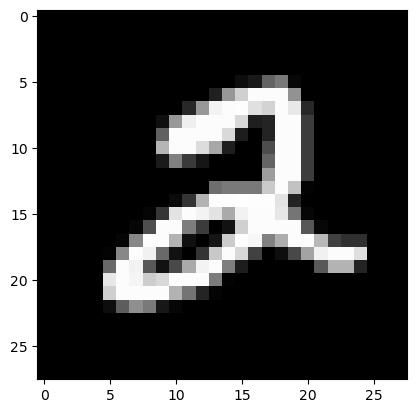

In [6]:
plt.imshow(x_train[5].reshape((28,28)), cmap='gray')
print(y_train[5])
plt.show()

### Convert numpy dataset to torch tensor

In [7]:
import torch

In [8]:
x_train, y_train, x_valid, y_valid = map( torch.tensor, (x_train, y_train, x_valid, y_valid))

#### Simple Test

In [34]:
# print(x_train[0].view(-1,1,28,28).shape)
# print(x_train[0].shape)

t = torch.rand(3,4)
print(t)

tensor([[0.2769, 0.8631, 0.5069, 0.3141],
        [0.7911, 0.8117, 0.1683, 0.9284],
        [0.3433, 0.3075, 0.0151, 0.5270]])


In [35]:
v = t.view(1,1,3,4)
print(v)

tensor([[[[0.2769, 0.8631, 0.5069, 0.3141],
          [0.7911, 0.8117, 0.1683, 0.9284],
          [0.3433, 0.3075, 0.0151, 0.5270]]]])


In [37]:
w = t.view(-1,1,3,4)
print(w)

tensor([[[[0.2769, 0.8631, 0.5069, 0.3141],
          [0.7911, 0.8117, 0.1683, 0.9284],
          [0.3433, 0.3075, 0.0151, 0.5270]]]])


In [58]:
x = t.view(12)
print(x.shape)
print(x.size(0))

torch.Size([12])
12


### Refactoring Dataset

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [10]:
batch_size = 64

In [11]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [12]:
# Function to get the dataset
def get_dataset(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size*2)
    )

### Training model using Neural Network

In [14]:
# Set up device (CPU / CUDA)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev = torch.device("cpu")

In [16]:
from torch import nn
import torch.nn.functional as F

In [17]:
loss_func = F.cross_entropy

In [18]:
lr = 0.5
epochs = 10

In [45]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [19]:
from torch import optim

In [48]:
def get_model():
    md = Mnist_NN()
    return md, optim.SGD(md.parameters(), lr=lr)

In [41]:
def batch_loss(model, loss_func, xb, yb, opt=None):
    xb = xb.to(dev)
    yb = yb.to(dev)
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()    
    return loss.item(), len(xb)

In [21]:
import numpy as np

In [36]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:           
            batch_loss(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[batch_loss(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(f"Epoch: {epoch}, Validation Loss : {val_loss}")


In [55]:
# Start training the model
train_dl, valid_dl = get_dataset(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Validation Loss : 0.3901370860338211
Epoch: 1, Validation Loss : 0.3253895290017128
Epoch: 2, Validation Loss : 0.32348976501226423
Epoch: 3, Validation Loss : 0.31267363609075544
Epoch: 4, Validation Loss : 0.28677646321058275
Epoch: 5, Validation Loss : 0.3314970516383648
Epoch: 6, Validation Loss : 0.28660190801620483
Epoch: 7, Validation Loss : 0.317992845928669
Epoch: 8, Validation Loss : 0.289930458432436
Epoch: 9, Validation Loss : 0.28539083164930346


### Training Model with Convolutional Neural Network

In [23]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))        
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
lr = 0.1


In [60]:
## Training CNN in (CPU)
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Validation Loss : 0.3224748212337494
Epoch: 1, Validation Loss : 0.31573773285746576
Epoch: 2, Validation Loss : 0.232510185110569
Epoch: 3, Validation Loss : 0.1854968361377716
Epoch: 4, Validation Loss : 0.18164973075389862
Epoch: 5, Validation Loss : 0.16128492228388785
Epoch: 6, Validation Loss : 0.142274890011549
Epoch: 7, Validation Loss : 0.14527072166204452
Epoch: 8, Validation Loss : 0.1562840872526169
Epoch: 9, Validation Loss : 0.1431595022559166


### Moving to GPU

In [37]:
print(torch.cuda.is_available())

True


In [57]:
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev = torch.device("cpu")

In [39]:
# Move model to GPU
model = Mnist_CNN()
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [40]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch: 0, Validation Loss : 0.3778861283779144
Epoch: 1, Validation Loss : 0.34632242302894595
Epoch: 2, Validation Loss : 0.2500240843772888
Epoch: 3, Validation Loss : 0.20283625326156615
Epoch: 4, Validation Loss : 0.21384643511772156
Epoch: 5, Validation Loss : 0.18765226073265076
Epoch: 6, Validation Loss : 0.18834423843622208
Epoch: 7, Validation Loss : 0.15095694166719914
Epoch: 8, Validation Loss : 0.17843367358446122
Epoch: 9, Validation Loss : 0.1343477134682238


### Clearing GPU memory

In [28]:
del model

In [29]:
import gc
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

0